## Анализ А/В тестирования по метрике линеаризованных лайков

В этом задании будем снова исследовать данные о пользователях, участвовавших в А/В тестировании, 
которое проходило с 2023-10-25 по 2023-10-31 включительно, но теперь с помощью метрики линеаризованных лайков.

В группе 2 был использован один из новых алгоритмов рекомендации постов, группа 1 использовалась в качестве контроля. 
Основная гипотеза заключается в том, что новый алгоритм во 2-й группе приведет к увеличению CTR.

Что за метрика линеаризованных лайков?

Вместо того, чтобы заталкивать в тест «поюзерные» CTR, можно сконструировать другую метрику и анализировать ее, но при этом гарантируется (в отличие от сглаженного CTR), что если тест на этой другой метрике «прокрасится» и увидит изменения, значит изменения есть и в метрике исходной (то есть в лайках на пользователя и в пользовательских CTR)

Итак,
 - Считаем общий CTR в контрольной группе  𝐶𝑇𝑅𝑐𝑜𝑛𝑡𝑟𝑜𝑙=𝑠𝑢𝑚(𝑙𝑖𝑘𝑒𝑠)/𝑠𝑢𝑚(𝑣𝑖𝑒𝑤𝑠) 
 - Посчитаем в обеих группах поюзерную метрику  𝑙𝑖𝑛𝑒𝑎𝑟𝑖𝑧𝑒𝑑_𝑙𝑖𝑘𝑒𝑠=𝑙𝑖𝑘𝑒𝑠−𝐶𝑇𝑅𝑐𝑜𝑛𝑡𝑟𝑜𝑙∗𝑣𝑖𝑒𝑤𝑠 
 - После чего сравним  t-тестом отличия в группах по метрике 𝑙𝑖𝑛𝑒𝑎𝑟𝑖𝑧𝑒𝑑_𝑙𝑖𝑘𝑒𝑠
 
#### Задачи:
1. Проанализировать тест между группами 0 и 3 по метрике линеаризованных лайков. Стало ли 𝑝−𝑣𝑎𝑙𝑢𝑒 меньше по сравнению с обычным CTR?

2. Проанализировать тест между группами 1 и 2 по метрике линеаризованных лайков.  Стало ли 𝑝−𝑣𝑎𝑙𝑢𝑒 меньше по сравнению с обычным CTR?

### 1. Подготовка к работе

In [1]:
import pandahouse as ph
import seaborn as sns
import numpy as np
from scipy import stats

### 2. Загрузка данных

In [3]:
#параметры соединения 
connection = {'host': 'https://clickhouse.lab.karpov.courses',
'database':'simulator_20231113',
'user':'student',
'password':'dpo_python_2020'
}

In [8]:

q = """
SELECT exp_group, 
    user_id,
    sum(action = 'like') as likes,
    sum(action = 'view') as views,
    likes/views as ctr
FROM {db}.feed_actions  
WHERE toDate(time) between '2023-10-25' and '2023-10-31'
    and exp_group in (0, 3)
GROUP BY exp_group, user_id
"""

### 3. Анализ данных

### Проанализируем T-test между группами 0 и 3 по метрике линеаризованных лайков

In [11]:
df = ph.read_clickhouse(q, connection=connection)

control_ctr = df[df.exp_group == 0].likes.sum()/df[df.exp_group == 0].views.sum()

df['linearized_likes'] = df['likes'] - control_ctr*df['views']

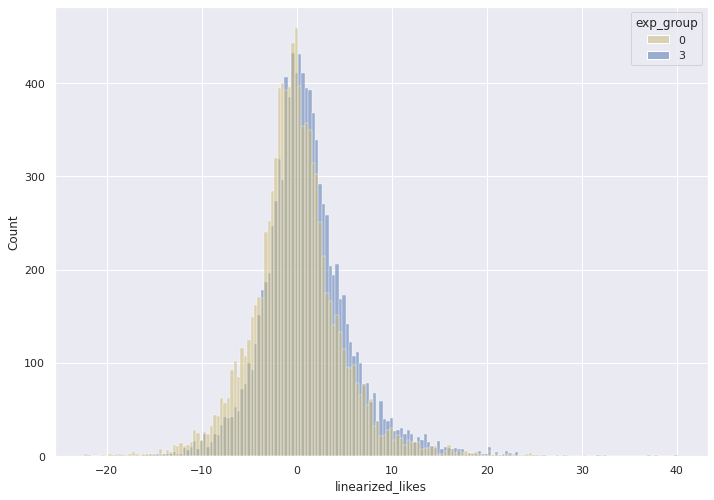

In [20]:
# Сделаем графики в seaborn покрупнее
sns.set(rc={'figure.figsize':(11.7,8.27)})

# построим гистограммы распределения значений CTR после эксперимента
groups = sns.histplot(data = df, 
              x='linearized_likes', 
              hue='exp_group', 
              palette=['y','b'],
              alpha=0.5,
              kde=False)

На графике видим, что линеаризованная метрика в группе 3 сдвинута относительно метрики группы 0.

In [22]:
# проведем т-тест для ctr

_, pvalue = stats.ttest_ind(df[df.exp_group == 0].ctr,
                            df[df.exp_group == 3].ctr,
                            equal_var=False)
print('T-test:')
if pvalue > 0.05:
    print('Не получилось отвергнуть нулевую гипотезу: различия не обнаружены, p-value:', pvalue)
else:
    print('Отвергаем нулевую гипотезу: cтатистически значимые различия есть, p-value:', pvalue)

T-test:
Отвергаем нулевую гипотезу: cтатистически значимые различия есть, p-value: 6.216047483062228e-44


In [24]:
# проведем т-тест для новой метрики

_, pvalue = stats.ttest_ind(df[df.exp_group == 0].linearized_likes,
                            df[df.exp_group == 3].linearized_likes,
                            equal_var=False)

print('T-test:')
if pvalue > 0.05:
    print('Не получилось отвергнуть нулевую гипотезу: различия не обнаружены, p-value:', pvalue)
else:
    print('Отвергаем нулевую гипотезу: cтатистически значимые различия есть, p-value:', pvalue)

1.4918137745326139e-58
T-test:
Отвергаем нулевую гипотезу: cтатистически значимые различия есть, p-value: 1.4918137745326139e-58


Для групп 0 и 2 p-value на линеаризованных метриках стал значительно меньше, чем при т-тесте на обычном CTR.

### Проанализируем T-test между группами 1 и 2 по метрике линеаризованных лайков

In [25]:
q = """
SELECT exp_group, 
    user_id,
    sum(action = 'like') as likes,
    sum(action = 'view') as views,
    likes/views as ctr
FROM {db}.feed_actions  
WHERE toDate(time) between '2023-10-25' and '2023-10-31'
    and exp_group in (1, 2)
GROUP BY exp_group, user_id
"""

In [26]:
df = ph.read_clickhouse(q, connection=connection)

control_ctr = df[df.exp_group == 1].likes.sum()/df[df.exp_group == 1].views.sum()

df['linearized_likes'] = df['likes'] - control_ctr*df['views']

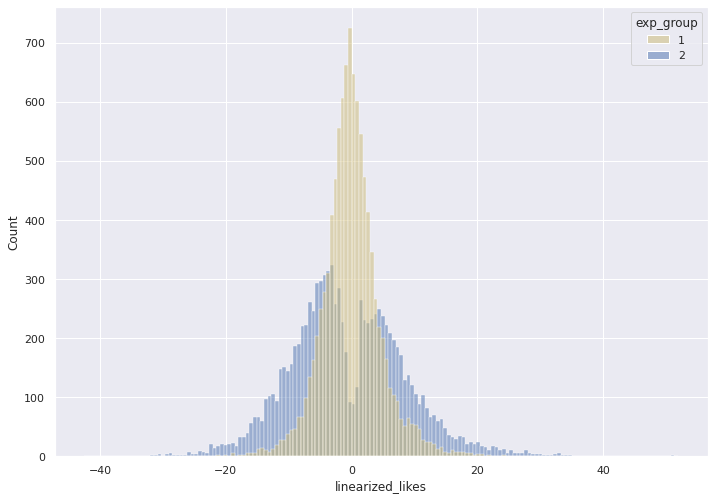

In [27]:
# построим гистограммы распределения значений CTR после эксперимента
groups = sns.histplot(data = df, 
              x='linearized_likes', 
              hue='exp_group', 
              palette=['y','b'],
              alpha=0.5,
              kde=False)

Стоит обратить внимание, что распределение для группы 2 стало более нормальным. В предыдущем задании мы видели, что распределение обычного CTR было близко к бимодальному.

In [28]:
# проведем т-тест для ctr

_, pvalue = stats.ttest_ind(df[df.exp_group == 1].ctr,
                            df[df.exp_group == 2].ctr,
                            equal_var=False)
print('T-test:')
if pvalue > 0.05:
    print('Не получилось отвергнуть нулевую гипотезу: различия не обнаружены, p-value:', pvalue)
else:
    print('Отвергаем нулевую гипотезу: cтатистически значимые различия есть, p-value:', pvalue)

T-test:
Не получилось отвергнуть нулевую гипотезу: различия не обнаружены, p-value: 0.685373331140751


In [29]:
# проведем т-тест для новой метрики

_, pvalue = stats.ttest_ind(df[df.exp_group == 1].linearized_likes,
                            df[df.exp_group == 2].linearized_likes,
                            equal_var=False)

print('T-test:')
if pvalue > 0.05:
    print('Не получилось отвергнуть нулевую гипотезу: различия не обнаружены, p-value:', pvalue)
else:
    print('Отвергаем нулевую гипотезу: cтатистически значимые различия есть, p-value:', pvalue)

T-test:
Отвергаем нулевую гипотезу: cтатистически значимые различия есть, p-value: 2.9805064038668164e-09


Видим, что т-тест на линеаризованных метриках показал, что различия есть в отличие от т-теста на обычном CTR.

### Выводы

Метод с линеаризованными метриками позволил сделать T-test более чувствительным без сложных вычислений:
 - для групп 0 и 2 p-value стал значительно меньше;
 - для групп 1 и 2 разница p-value оказалась ещё более значительной и позволила обнаружить статистически значимые различия в отличии от т-теста на обычном CTR.